# Rejection sampling

## Takeaways and objectives from this notebook

There are some similarities between importance and [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling). Rejection sampling also uses an auxiliary (designed) probabiliy density $q(x)$ to guide the sampling process. However, rejection sampling brings in a key new idea: **not all Monte Carlo samples are accepted, some are rejected.**

We need to assume that we know a value $M \in {\cal R}$ s.t. $\forall x \in {\cal R} \; p(x)/q(x) \leq M$.  Note that the ratio $p(x)/q(x)$ is the **likelihood ratio** we encountered in importance sampling. In particular, this means we can assume that $Mq(x) > p(x)$ is always true.

### The rejection sampling algorithm

1. Draw a sample from $q(x)$.
2. Draw a value $u \sim U[0,1]$.
3. If $Mu < p(x)/q(x)$ then accept sample, otherwise reject.
4. Goto 1.

The samples that we accept are drawn from the distribution $p(x)$.

### Example

We will use the same functions $p(x)$ and $q(x)$ we used for importance sampling but this time $q(x)$ will be setup reasonably well for you :) - no more tricks, that's a promise.

In [1]:
import numpy as np
from scipy.stats import norm
import seaborn as sns

# This function definition will also work on lists and np.arrays
def eval_p(x):
    return (1./8/np.pi)**0.5*np.exp(-0.5*(x-3)**2) + (1./16/np.pi)**0.5*np.exp(-0.25*(x-6)**2)

# Parameters of our designed (Gaussian) distribution q(x)
q_mean = 0.
q_stdev = 5.
M = 5.

def designed_q(x):
    return norm.pdf(x, loc=q_mean, scale=q_stdev)

def sample_q(size):
    return norm.rvs(loc=q_mean,scale=q_stdev,size=size)


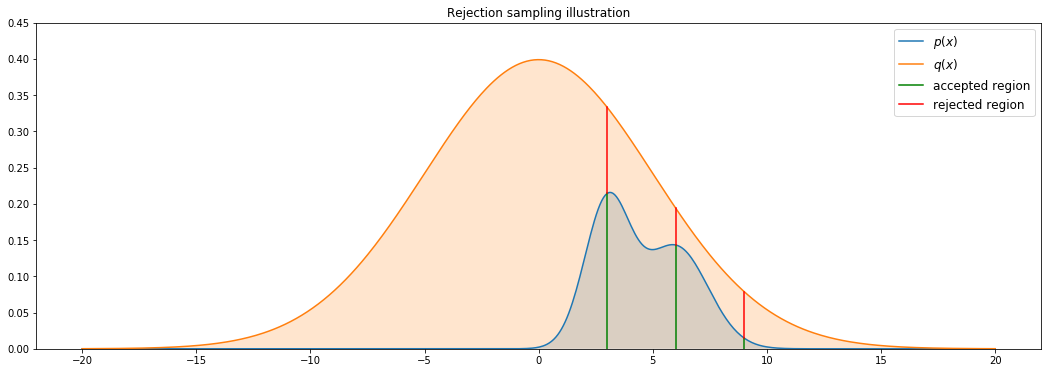

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# we shall illustrate rejection sampling using a fiture
x = np.linspace(-20, 20, 500)
fig = plt.figure(figsize=(18,6))
plt.plot(x, eval_p(x), label = '$p(x)$')
fig.gca().fill_between(x, 0, eval_p(x), alpha=0.2)
plt.plot(x, M * designed_q(x), label = '$q(x)$')
fig.gca().fill_between(x, 0, M * designed_q(x), alpha=0.2)

plt.plot([3, 3], [0, eval_p(3)], color='g', label='accepted region')
plt.plot([3, 3],  [eval_p(3), M*designed_q(3)], color='r', label='rejected region')
plt.plot([6, 6], [0, eval_p(6)], color='g')
plt.plot([6, 6],  [eval_p(6), M*designed_q(6)], color='r')
plt.plot([9, 9], [0, eval_p(9)], color='g')
plt.plot([9, 9],  [eval_p(9), M*designed_q(9)], color='r')

plt.ylim([0, 0.45])
plt.legend(fontsize=12)
_ = plt.title('Rejection sampling illustration')

Let us think about the graphical illustration of the rejection sample and look at the algorithm from another perspective.

1. We sample from $q(x)$ to obtain a point $x$ and we compute $q(x)$, the density itself.
2. We then sample $u \sim U[0,1]$ and we map $u$ the point $uMq(x) \in [0,Mq(x)]$.
3. If the point $uMq(x) \leq p(x)$ meaning it's in the green part of the line, we consider the point a hit and accept it.
4. If the point is above $p(x)$, we consider it a miss and reject it.

We argue (informally) as follows: drawing samples from $q(x)$ uniformly distributes samples in the orange region under $q(x)$ everywhere, that is including in the blue region under $p(x)$).  The algorithm above rejects all samples that are in the orange region but not in the blue region. The remaining samples must therefore be uniformly distributed in the blue region under $p(x)$.  Thus the accepted samples $x_i$ reflect the density of $p(x)$, since where $p(x)$ is larger, there will be more samples $x$.

**Note**: it's not at all trivial to ensure that $Mq(x) \geq p(x)$ everywhere but in this example $M=5$ ensures this condition.

In [3]:
# The sample is written using a loop in purpose.  Monte Carlo is embarassingly parallel and all the operations could be done at the same time on all samples.
def rejection_sampler(n, M):
    # sample from q(x) and also compute densities q(x) and p(x) for the x values
    samples_q = sample_q(n)
    samples_p = []

    # could be written as a list comprehension but may be harder to parse
    for x,u in zip(samples_q, np.random.uniform(size=n)):
        if u*M*designed_q(x) <= eval_p(x):
            samples_p.append(x)

    return samples_p

### Question

If you run this sample, with the settings in this notebook, it will accept about 20% of the samples (see below).  This may seem inefficient.  How could we improve the acceptance ratio?

In [4]:
len(rejection_sampler(1000, 5)) / 1000.

0.2

### Compare results
Let us plot the density $p(x)$ and compare it to a kernel density estimate based on our rejection sampler. 

<Figure size 864x432 with 0 Axes>

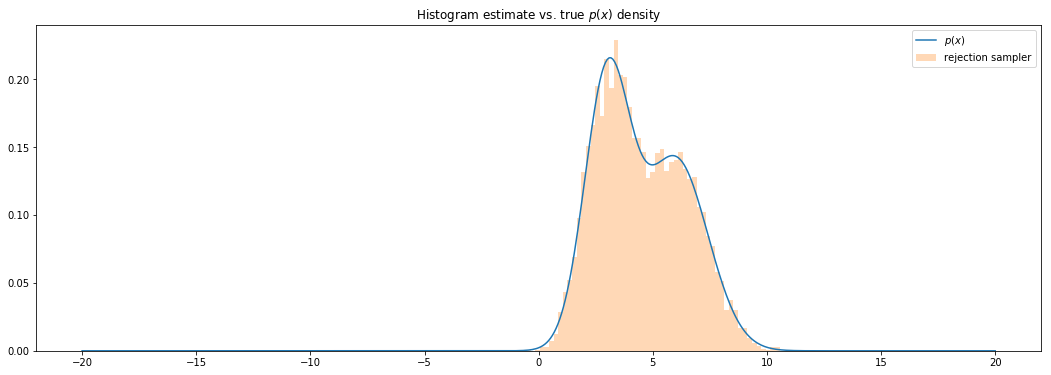

In [5]:
samples_p = rejection_sampler(30000, 5)

plt.figure(figsize=(12,6))
x = np.linspace(-20, 20, 500)
fig = plt.figure(figsize=(18,6))
plt.plot(x, eval_p(x), label = '$p(x)$')
#sns.kdeplot(samples_p)
plt.hist(samples_p, bins=np.linspace(-5, 15, 100), density=True, alpha=0.3,label='rejection sampler')
plt.title('Histogram estimate vs. true $p(x)$ density')
_ = plt.legend()

### Exercise 
Observe that if we set the value $M=0.5$, the inequality $p(x) < Mq(x)$ ceases to hold everywhere and our histogram becomes skewed. Think back to the rejection sampling algorithm above and explain why this happens.

<Figure size 864x432 with 0 Axes>

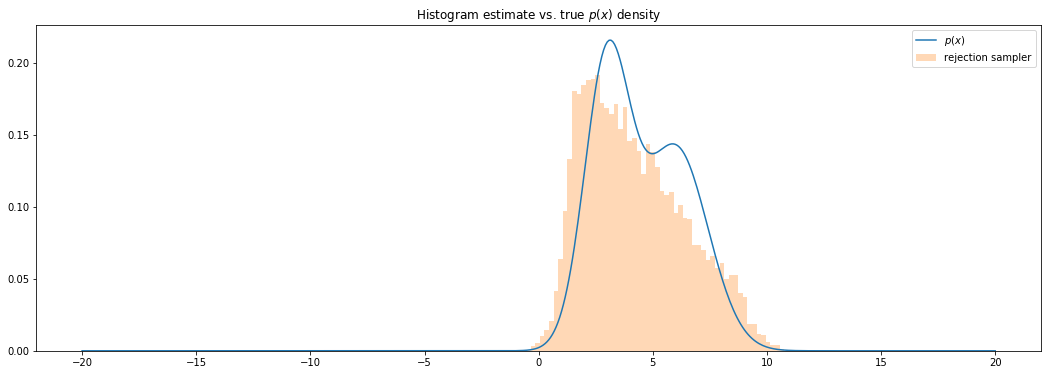

In [6]:
samples_p = rejection_sampler(30000, 0.5)

plt.figure(figsize=(12,6))
x = np.linspace(-20, 20, 500)
fig = plt.figure(figsize=(18,6))
plt.plot(x, eval_p(x), label = '$p(x)$')
#sns.kdeplot(samples_p)
plt.hist(samples_p, bins=np.linspace(-5, 15, 100), density=True, alpha=0.3,label='rejection sampler')
plt.title('Histogram estimate vs. true $p(x)$ density')
_ = plt.legend()

### Thinking material and exercise

Examine the code of the rejection sampler. Note that the only way information from $p(x)$, which we are supposed to be estimating, only enters the routine via the reject/accept step. Removing this step will result in the samples being drawn from $q(x)$, so the rejection is critical.  The rejection rate depends on $x$ as the different proportions of green/red lines in the illustration image above shows and this is exactly what reshapes $q(x)$ into $p(x)$. Think about the very key role of the rejection step - the same thinking with a twist applies to the Metropolis sampler.

- We cannot use an $M$ value that's too low since then $p(x) > q(x)$ for some $x$, thus invalidating the math of the rejection sampler. You have seen this happen above.
- What happens if we used a higher $M$? How is the sampling process and the resulting distribution affected?

### Note on generating samples from the Standard Normal distribution

Rejection sampling is among the most effective ways to draw samples from ${\cal N}(0,1)$, the standard normal distribution. **Numpy** uses this algorithm for `numpy.random.randn` as can be seen in the [source code](https://github.com/numpy/numpy/blob/e3fe42f0473d41f97db5a40e3ddd067391df57f0/numpy/random/mtrand/randomkit.c#L601).  The source code there generates two samples from ${\cal N}(0,1)$ using two samples from $U[0,1]$ using the Box-Muller transform as follows:

1. Sample $x,y$ from $U[-1,1]$.
2. If $x^2+y^2 <= 1$ accept and goto 3, else reject and goto 1.
3. Transform $x,y$ into two normally distributed samples $a,b$ using [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform).

Note that the method runs only once per two samples, so whenever two samples are generated, one is returned and the other is stored for the next function invocation.

## Other sampling methods

### Slice sampling
In rejection sampling, we have to ensure that our designed (and multiplied) density $Mq(x)$ dominates the density of interest $p(x)$ everywhere.  This can be difficult, since it's typically the case that we don't know the properties of $p(x)$.  Slice sampling solves this problem by iteratively finding a suitable region to sample.  For an introduction, see the lecture [1] by David MacKay.

## References

1. David Mackay. [Lecture 13: Approximating Probability Distributions (III): Monte Carlo Methods (II): Slice Sampling](https://youtu.be/Qr6tg9oLGTA?t=4122).  Note: the video starts directly in the slice sampling section.  The entire video is recommended viewing though.